# Performing gradient optimization of a pulse sequence

Here we walk through an example of optimizing a single qubit gate using `qiskit_dynamics`. This tutorial requires JAX - see the How-to guide on using JAX for more detail on how to configure `qiskit-dynamics` to work with JAX. 

We will optimize an $X$-gate on a model of a qubit system using the following steps:

1. Configure `qiskit-dynamics` to work with the JAX backend. 
2. Setup a `Solver` instance with the model of the system. 
3. Define a pulse sequence parameterization to optimize over. 
4. Define gate fidelity function.
5. Define objective function for optimization.
6. Use JAX to differentiate objective, then gradient optimize.

## 1. Configure to use JAX

First, set JAX to operate in 64-bit mode, and set it as the default backend for `qiskit-dynamics`.

In [1]:
import jax
jax.config.update("jax_enable_x64", True)

from qiskit_dynamics import dispatch
dispatch.set_default_backend('jax')

## 2. Setup the solver

Here we will setup a `Solver` with a simple model of a qubit. The Hamiltonian is:

$$H(t) = 2 \pi \nu \frac{Z}{2} + 2 \pi r s(t) \frac{X}{2}$$

We will setup the problem to be in the rotating frame of the drift term.

Also note: The `Solver` is initialized *without* signals, as we will update these and optimize over this later.

In [2]:
import numpy as np
from qiskit.quantum_info import Operator
from qiskit_dynamics import Solver

v = 5.
r = 0.02

static_hamiltonian = 2 * np.pi * v * Operator.from_label('Z') / 2
drive_term = 2 * np.pi * r * Operator.from_label('X') / 2

ham_solver = Solver(hamiltonian_operators=[drive_term],
                    static_hamiltonian=static_hamiltonian,
                    rotating_frame=static_hamiltonian)

## 3. Define a pulse sequence parameterization to optimize over

We will optimize over a set of signals that are: 

- On resonance with piecewise constant envelopes,
- Envelopes bounded between $[-1, 1]$,
- Envelopes are smooth, in the sense that the change between adjacent samples is small, and
- Envelope starts and ends at $0$.

In setting up our parameterization, we need t keep in mind that we will use the BFGS optimization routine, and hence: 

- Optimization parameters must be *unconstrained*.
- Parameterization must be JAX-differentiable.

We implement a parameterization as follows:

- Input: Array `x` of real values.
- "Normalize" `x` by applying a JAX-differentiable function from $\mathbb{R} \rightarrow [-1, 1]$.
- Pad the normalized `x` with a $0.$ to start.
- "Smoothen" the above via convolution.
- Construct the signal using the above as the samples for a piecewise-constant envelope, with carrier frequency on resonance.

We remark that there are many other parameterizations that may achieve the same ends, and may have more efficient strategies for achieving a value of $0$ at the beginning and end of the pulse. This is only meant to demonstrate the need for such an approach, and one simple example of one.

In [3]:
from qiskit_dynamics.dispatch import Array
from qiskit_dynamics.signals import DiscreteSignal, Convolution

# define convolution filter
def gaus(t):
    sigma = 15
    _dt = 0.1
    return 2.*_dt/np.sqrt(2.*np.pi*sigma**2)*np.exp(-t**2/(2*sigma**2))

convolution = Convolution(gaus)

# define function mapping parameters to signals
def signal_mapping(params):
    samples = Array(params)
    
    # map samples into [-1, 1]
    bounded_samples = np.arctan(samples) / (np.pi / 2)
    
    # pad with 0 at beginning
    padded_samples = np.append(Array([0], dtype=complex), bounded_samples)
    
    # apply filter
    output_signal = convolution(DiscreteSignal(dt=1., samples=padded_samples))
    
    # set carrier frequency to v
    output_signal.carrier_freq = v
    
    return output_signal

Observe, for example, the signal generated when all parameters are $10^8$:

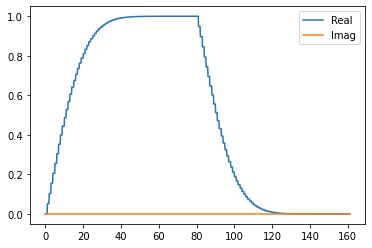

In [4]:
signal = signal_mapping(np.ones(80) * 1e8)
signal.draw(t0=0., tf=signal.duration * signal.dt, n=1000, function='envelope')

## 4. Define gate fidelity

We will optimize an $X$ gate, and define the fidelity of a unitary via the standard fidelity measure:

$$f(U) = \frac{|\text{Tr}(XU)|^2}{4}$$

In [5]:
X_op = Array(Operator.from_label('X'))

def fidelity(U):
    U = Array(U)
    
    return np.abs(np.sum(X_op * U))**2 / 4.

## 5. Define the objective function

The function we want to optimize consists of:

- Taking a list of input samples and applying the signal mapping.
- Simulating the Schrodinger equation over the length of the pulse sequence.
- Computing and return the infidelity (we minimize $1-f(U)$).

In [6]:
def objective(params):
    
    # apply signal mapping and set signals
    signal = signal_mapping(params)
    solver_copy = ham_solver.copy()
    solver_copy.signals = [signal]
    
    # Simulate
    results = solver_copy.solve(y0=np.eye(2, dtype=complex), 
                                t_span=[0, signal.duration * signal.dt],
                                method='jax_odeint', atol=1e-8, rtol=1e-8)
    U = results.y[-1]
    
    # compute and return infidelity
    fid = fidelity(U)
    return 1. - fid.data

## 6. Perform JAX transformations and optimize

Finally, we gradient optimize the objective: 

- Use `jax.value_and_grad` to transform the objective into a function that computes both the objective and the gradient.
- Use `jax.jit` to compile the above.
- Call `scipy.optimize.minimize` with the above, with `method='BFGS'` and `jac=True` to indicate that the passed objective also computes the gradient.

In [7]:
from jax import jit, value_and_grad
from scipy.optimize import minimize

jit_grad_obj = jit(value_and_grad(objective))

initial_guess = np.random.rand(80) - 0.5

opt_results = minimize(fun=jit_grad_obj, x0=initial_guess, jac=True, method='BFGS')
print(opt_results.message)
print('Number of function evaluations: ' + str(opt_results.nfev))
print('Function value: ' + str(opt_results.fun))

Optimization terminated successfully.
Number of function evaluations: 12
Function value: -3.28263383142513e-08


The gate is optimized to an $X$ gate, with deviation within the numerical accuracy of the solver. 

We can draw the optimized signal, which is retrieved by applying the `signal_mapping` to the optimized parameters.

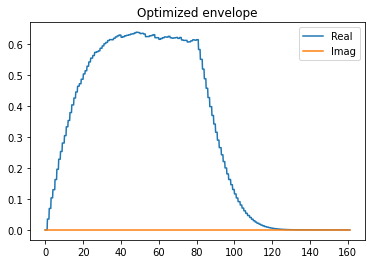

In [8]:
opt_signal = signal_mapping(opt_results.x)

opt_signal.draw(t0=0, tf=opt_signal.duration * opt_signal.dt, 
                n=1000, function='envelope', title='Optimized envelope')

Summing the signal samples yeilds approximately $\pm 50$, which is equivalent to what one would expect based on a rotating wave approximation analysis.

In [9]:
opt_signal.samples.sum()

Array(49.99506973)